In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/bootcamp/Averiguacao Cadastral/Data_modelo

/content/drive/MyDrive/bootcamp/Averiguacao Cadastral/Data_modelo


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Load the datasets
df_familia_pessoas_final = pd.read_csv('df_modelo.csv', sep=',')
#df_familia_pessoas_final = df_familia_pessoas_final.sample(10000)

In [ ]:
df_familia_pessoas_final.columns

Index(['uf_ibge', 'classf', 'id_familia', 'cod_local_domic_fam',
       'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'cod_iluminacao_domic_fam', 'ind_parc_mds_fam', 'qtde_pessoas',
       'dias_cadastramento', 'dias_atualizacao', 'classe_renda', 'rf_idade',
       'rf_trab_principal', 'rf_com_deficiencia', 'rf_trab_agricultura',
       'rf_sexo', 'rf_curso_frequentou', 'rf_curso_frequenta',
       'rf_trabalhou_semana', 'rf_cor_raca', 'rf_concluiu_curso',
       'pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escolar_nunca_freq_escola',
       'pct_freq_creche', 'pct_idosos', 'pc

In [ ]:
df_familia_pessoas_final = df_familia_pessoas_final [['pct_idosos',
                                                       'classe_renda']
]

In [ ]:
# Selecionando as variáveis que serão utilizadas para o modelo
X = df_familia_pessoas_final.drop('classe_renda', axis=1)

y = df_familia_pessoas_final['classe_renda']

# Exibindo as informações de X
print('X =', X.shape)
X.head()

X = (96502, 1)


,pct_idosos
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


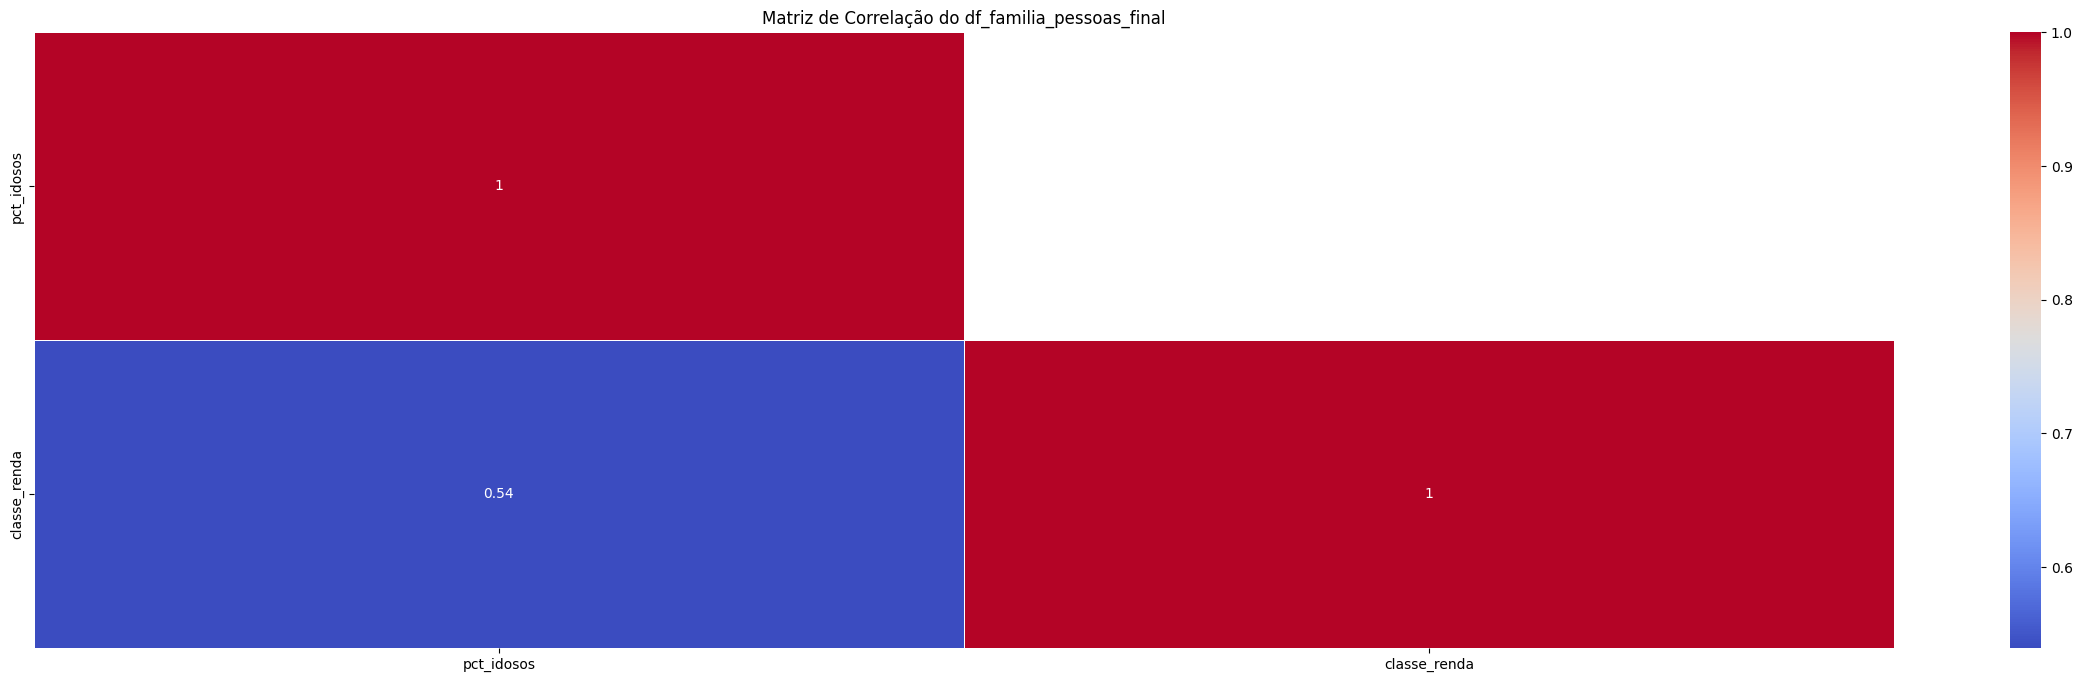

In [ ]:
# Calculando a matriz de correlação
correlation_matrix = df_familia_pessoas_final.corr()

# Calculando a matriz de correlação
correlation_matrix = df_familia_pessoas_final.corr()

# Máscara para a parte superior da matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plotando o gráfico de correlações com a máscara
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação do df_familia_pessoas_final')
plt.show()

In [ ]:
# Selecionar apenas as colunas numéricas
numeric_cols = df_familia_pessoas_final.select_dtypes(include=np.number).columns

# Calcular a matriz de correlação
corr_matrix = df_familia_pessoas_final[numeric_cols].corr()

# Encontrar as correlações com valor absoluto maior que 0.8
corr_strong = corr_matrix[abs(corr_matrix) > 0.8]

# Imprimir as correlações fortes
for col in corr_strong.columns:
    for row in corr_strong.index:
        if col != row and corr_strong.loc[row, col] > 0.8:
            print(f"Correlação forte entre {row} e {col}: {corr_strong.loc[row, col]}")

In [ ]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Mapeando y_train e y_test se necessário (exemplo)
y_train_mapped = y_train.astype('int')
y_test_mapped = y_test.astype('int')

In [ ]:
y_train_mapped.describe()

,classe_renda
count,77201.000000
mean,0.618243
std,0.800525
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


# Fazendo um pipeline comparando diversos modelos

In [ ]:
!pip install xgboost -q

In [ ]:
# Importações necessárias
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# 1. Definição dos Modelos

In [ ]:
# Definir os modelos e os parâmetros
models = {
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
        'param_grid': {
            'classifier__n_estimators': [100, 200, 250, 300],  # Testando mais valores
            'classifier__max_depth': [3, 4, 5, 6],  # Adicionando mais profundidades
            'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]  # Variando a taxa de aprendizado
        }
    }
}

# 2. Treinamento e Busca de Hiperparâmetros

In [ ]:
# Criar um dicionário para armazenar os melhores modelos
best_models = {}

for model_name, model_info in models.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Definir GridSearchCV
    grid_search = GridSearchCV(pipeline, model_info['param_grid'], cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train_mapped)

    # Armazenar o melhor modelo
    best_model = grid_search.best_estimator_
    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

    # Realizando a validação cruzada com o melhor modelo
    cv_scores = cross_val_score(best_model, X_train, y_train_mapped, cv=3, scoring='f1_macro', n_jobs=-1)
    print(f"Pontuações de validação cruzada para {model_name}: {cv_scores}")
    print(f"Média das pontuações F1 de validação cruzada para {model_name}: {cv_scores.mean()}")
    cv_scores = cross_val_score(best_model, X_train, y_train_mapped, cv=3, scoring='accuracy', n_jobs=-1)
    print(f"Pontuações de validação cruzada para {model_name}: {cv_scores}")
    print(f"Média das pontuações Acc de validação cruzada para {model_name}: {cv_scores.mean()}")

Melhores hiperparâmetros para XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__n_estimators': 100}
Pontuações de validação cruzada para XGBoost: [0.54653292 0.54937102 0.54718621]
Média das pontuações F1 de validação cruzada para XGBoost: 0.5476967193271558
Pontuações de validação cruzada para XGBoost: [0.69040957 0.69215823 0.6900478 ]
Média das pontuações Acc de validação cruzada para XGBoost: 0.6908718692235764


# 3. Avaliação do Modelo

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Avaliar todos os modelos
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    # Calcular F1 Score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Calcular Acurácia
    accuracy = accuracy_score(y_test, y_pred)

    # Exibir os resultados
    print(f"Modelo: {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo: XGBoost
  F1 Score: 0.55
  Acurácia: 0.69


# 4. Geração de Matriz de Confusão

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

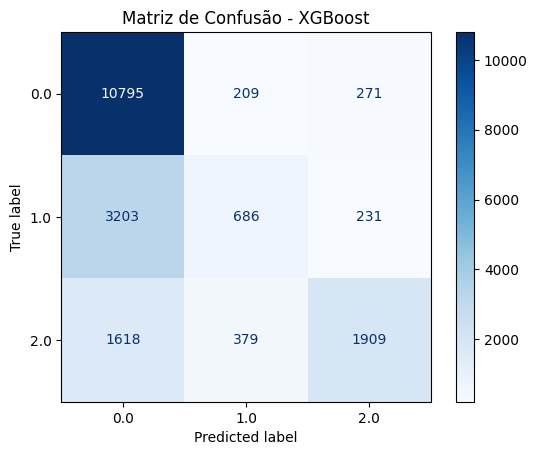

In [ ]:
# Gerar matriz de confusão para cada modelo
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

# 5. Análise da Importância das Features

In [ ]:
import numpy as np
from sklearn.inspection import permutation_importance

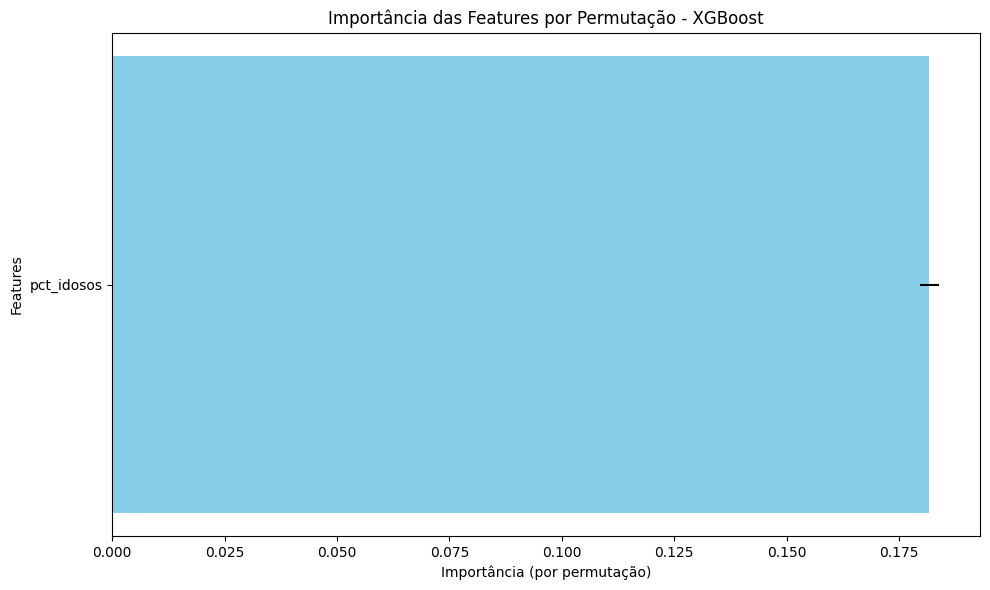

In [ ]:
# Importância das features para cada modelo
for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Ordenar importâncias
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    indices = np.argsort(importance_vals)[::-1]

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.title(f"Importância das Features por Permutação - {model_name}")
    plt.barh(range(len(importance_vals)), importance_vals[indices], xerr=importance_std[indices], align="center", color='skyblue')
    plt.yticks(range(len(importance_vals)), X_test.columns[indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Importância (por permutação)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [ ]:
# Lista para armazenar as 5 principais features de cada modelo
top_features_list = {}

# Obter as 5 features mais importantes de cada modelo
for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Extrair valores de importância e índices
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Obter as 5 principais features e suas importâncias
    top_indices = indices[:10]
    top_features = X_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Armazenar em um DataFrame
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Adicionar ao dicionário
    top_features_list[model_name] = top_features_df

# Exibir as 5 principais features de cada modelo
for model_name, top_features_df in top_features_list.items():
    print(f"\n5 Features mais importantes para o modelo {model_name}:")
    print(top_features_df)


5 Features mais importantes para o modelo XGBoost:
      Feature  Importância
0  pct_idosos     0.181763


# Avaliando o balanceamento das classes

In [ ]:
# Verificar a distribuição da variável target
target_distribution = y.value_counts(normalize=True)

In [ ]:
print("Distribuição da variável target 'classe_renda':")
print(target_distribution)

Distribuição da variável target 'classe_renda':
classe_renda
0.0    0.584164
1.0    0.213436
2.0    0.202400
Name: proportion, dtype: float64


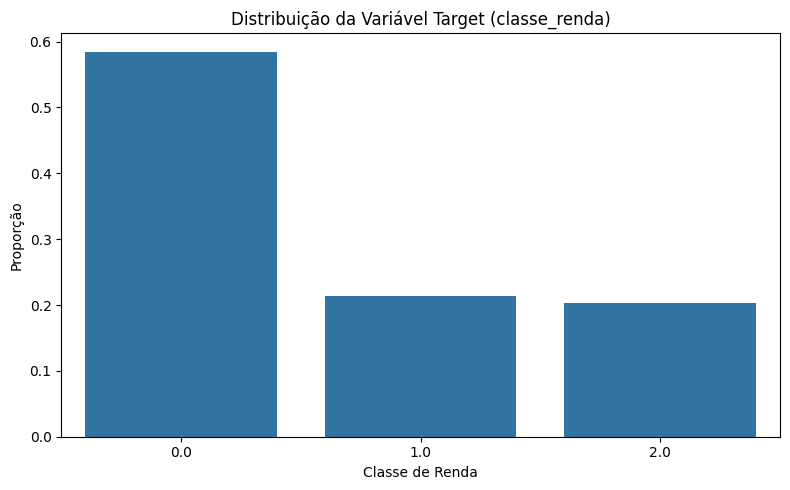

In [ ]:
# Plotar a distribuição da variável target
plt.figure(figsize=(8, 5))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda)')
plt.xlabel('Classe de Renda')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Exibir o número absoluto de ocorrências por classe
absolute_distribution = y.value_counts()

print("\nNúmero absoluto de ocorrências por classe:")
print(absolute_distribution)


Número absoluto de ocorrências por classe:
classe_renda
0.0    56373
1.0    20597
2.0    19532
Name: count, dtype: int64


## Balanceando as classes

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
df_familia_pessoas_final.classe_renda.value_counts()

,count
classe_renda,
0.0,56373
1.0,20597
2.0,19532


In [ ]:
y.value_counts()

,count
classe_renda,
0.0,56373
1.0,20597
2.0,19532


In [ ]:
# Suponha que 'y' seja sua variável alvo e '0.0' seja a classe majoritária
n_samples_majority = y.value_counts()[0.0]

# Oversampling da classe '1.0' para 30% da classe majoritária
n_samples_1 = int(y.value_counts()[1.0])

# Oversampling da classe '2.0' para 40% da classe majoritária
n_samples_2 = int(y.value_counts()[2.0])

# Undersampling da classe '0.0' para 70% do tamanho original
n_samples_0 = int((n_samples_1+n_samples_2)/2)

over = SMOTE(sampling_strategy={1.0: n_samples_1, 2.0: n_samples_2})
under = RandomUnderSampler(sampling_strategy={0.0: n_samples_0})

In [ ]:
# Criar um pipeline que aplica SMOTE e depois o undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])

In [ ]:
# Aplicar o balanceamento ao conjunto de dados
X_balanced, y_balanced = pipeline.fit_resample(X, y)

In [ ]:
# Verificar a nova distribuição das classes
balanced_distribution = pd.Series(y_balanced).value_counts()

print("Distribuição da variável target 'classe_renda' após o balanceamento:")
print(balanced_distribution)

Distribuição da variável target 'classe_renda' após o balanceamento:
classe_renda
1.0    20597
0.0    20064
2.0    19532
Name: count, dtype: int64


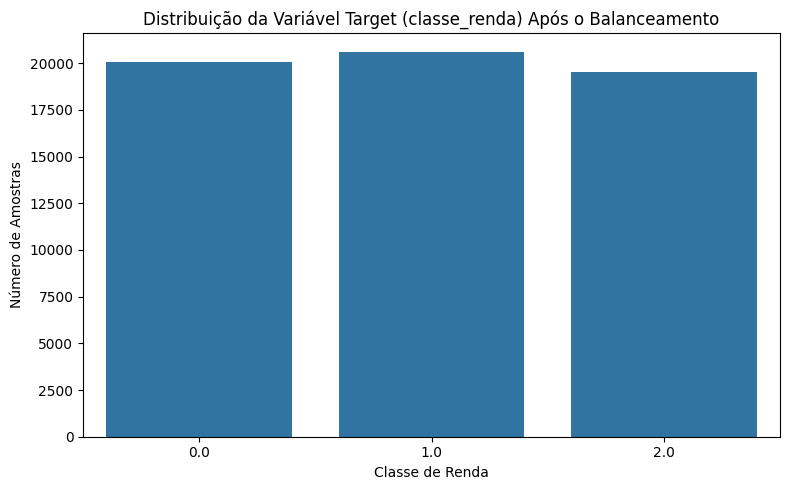

In [ ]:
# Visualizar a distribuição das classes após o balanceamento
plt.figure(figsize=(8, 5))
sns.barplot(x=balanced_distribution.index, y=balanced_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda) Após o Balanceamento')
plt.xlabel('Classe de Renda')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Refazendo as análises dos modelos após balanceamento das classes

In [ ]:
X_balanced.head()

,pct_idosos
56746,0.0
57252,0.0
65701,0.0
87756,0.0
26484,0.0


In [ ]:
print(X_balanced.shape)
print(y_balanced.shape)

(60193, 1)
(60193,)


In [ ]:
print(y_balanced.shape)
print(y.shape)  # Verifique se y é igual a y_balanced

(60193,)
(96502,)


In [ ]:
# Dividir os dados em treino e teste após balanceamento
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [ ]:
# Definir os modelos e os parâmetros
models_balanced = {
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
        'param_grid': {
            'classifier__n_estimators': [100, 200, 250, 300],  # Testando mais valores
            'classifier__max_depth': [3, 4, 5, 6],  # Adicionando mais profundidades
            'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]  # Variando a taxa de aprendizado
        }
    }
}

In [ ]:
# Parte 3: Criar um dicionário para armazenar os melhores modelos
best_models_balanced = {}

for model_name, model_info in models_balanced.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Definir GridSearchCV usando as features e classes balanceadas
    grid_search = GridSearchCV(pipeline, model_info['param_grid'], cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_balanced_train, y_balanced_train)  # Usando dados balanceados

    # Armazenar o melhor modelo
    best_model = grid_search.best_estimator_
    best_models_balanced[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name} (usando dados balanceados): {grid_search.best_params_}")

    # Realizando a validação cruzada com o melhor modelo
    cv_scores = cross_val_score(best_model, X_balanced_train, y_balanced_train, cv=3, scoring='f1_macro', n_jobs=-1)
    print(f"Pontuações de validação cruzada para {model_name}: {cv_scores}")
    print(f"Média das pontuações F1 de validação cruzada para {model_name}: {cv_scores.mean()}")

        # Realizando a validação cruzada com o melhor modelo
    cv_scores = cross_val_score(best_model, X_balanced_train, y_balanced_train, cv=3, scoring='accuracy', n_jobs=-1)
    print(f"Pontuações de validação cruzada para {model_name}: {cv_scores}")
    print(f"Média das pontuações Acc de validação cruzada para {model_name}: {cv_scores.mean()}")



Melhores hiperparâmetros para XGBoost (usando dados balanceados): {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Pontuações de validação cruzada para XGBoost: [0.49619955 0.48768559 0.49298875]
Média das pontuações F1 de validação cruzada para XGBoost: 0.49229129936096466
Pontuações de validação cruzada para XGBoost: [0.5352604  0.52812909 0.53249019]
Média das pontuações Acc de validação cruzada para XGBoost: 0.5319598932485268


In [ ]:
# Parte 4: Avaliar todos os modelos usando dados balanceados
from sklearn.metrics import f1_score, accuracy_score
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_balanced_test)  # Usando dados de teste balanceados

    # Calcular F1 Score
    f1 = f1_score(y_balanced_test, y_pred, average='macro')

    # Calcular Acurácia
    accuracy = accuracy_score(y_balanced_test, y_pred)

    # Exibir os resultados
    print(f"Modelo (usando dados balanceados): {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo (usando dados balanceados): XGBoost
  F1 Score: 0.49
  Acurácia: 0.53


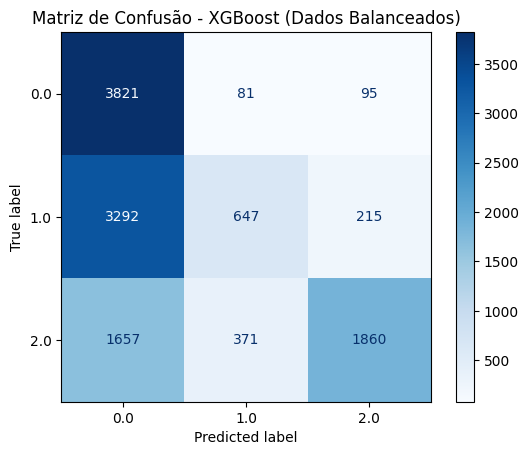

In [ ]:
# Parte 5: Gerar matriz de confusão para cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_balanced_test)  # Usar os dados de teste balanceados

    # Gerar a matriz de confusão
    ConfusionMatrixDisplay.from_estimator(model, X_balanced_test, y_balanced_test, cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name} (Dados Balanceados)')
    plt.show()

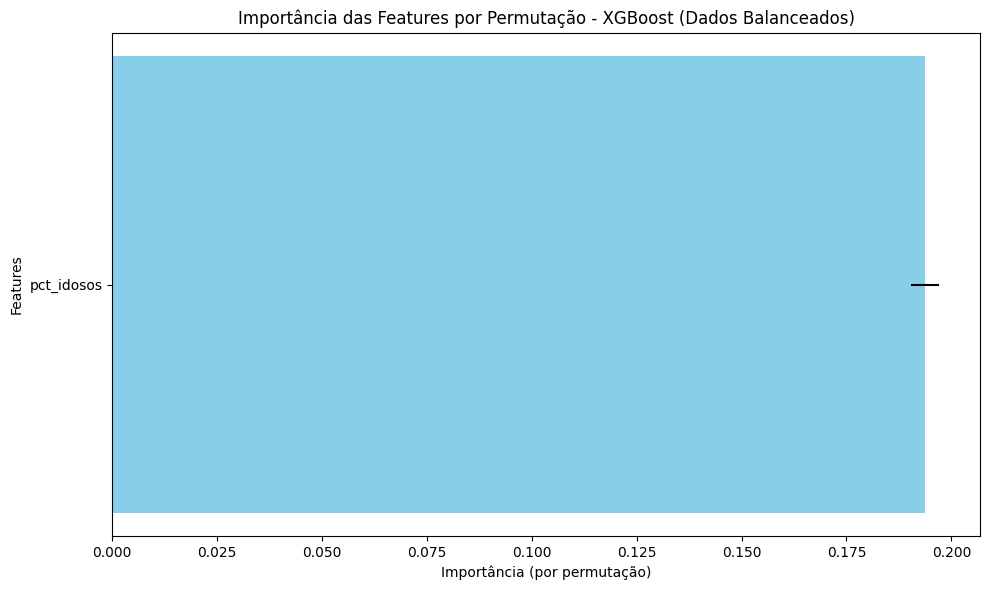

In [ ]:
# Parte 6: Importância das features para cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Ordenar importâncias
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    indices = np.argsort(importance_vals)[::-1]

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.title(f"Importância das Features por Permutação - {model_name} (Dados Balanceados)")
    plt.barh(range(len(importance_vals)), importance_vals[indices], xerr=importance_std[indices], align="center", color='skyblue')
    plt.yticks(range(len(importance_vals)), X_balanced_test.columns[indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Importância (por permutação)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()



In [ ]:
# Parte 7: Lista para armazenar as 5 principais features de cada modelo
top_features_list = {}

# Obter as 5 features mais importantes de cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Extrair valores de importância e índices
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Obter as 5 principais features e suas importâncias
    top_indices = indices[:10]
    top_features = X_balanced_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Armazenar em um DataFrame
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Adicionar ao dicionário
    top_features_list[model_name] = top_features_df

# Exibir as 5 principais features de cada modelo
for model_name, top_features_df in top_features_list.items():
    print(f"\n10 Features mais importantes para o modelo {model_name} (Dados Balanceados):")
    print(top_features_df)



10 Features mais importantes para o modelo XGBoost (Dados Balanceados):
      Feature  Importância
0  pct_idosos     0.193662


# Comparando a performance antes e após o balanceamento

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance

In [ ]:
# Lista para armazenar as métricas de desempenho
performance_comparison = []

# Avaliar modelos antes do balanceamento
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    # Calcular F1 Score e Acurácia
    f1_before = f1_score(y_test, y_pred, average='macro')
    accuracy_before = accuracy_score(y_test, y_pred)

    # Armazenar os resultados antes do balanceamento
    performance_comparison.append({
        'Modelo': model_name,
        'F1 Score Antes do Balanceamento': f1_before,
        'Acurácia Antes do Balanceamento': accuracy_before,
        'F1 Score Após o Balanceamento': None,  # Inicializa como None
        'Acurácia Após o Balanceamento': None,  # Inicializa como None
    })


In [ ]:
# Avaliar modelos após o balanceamento
for model_name, model in best_models_balanced.items():
    y_pred_balanced = model.predict(X_balanced_test)

    # Calcular F1 Score e Acurácia
    f1_balanced = f1_score(y_balanced_test, y_pred_balanced, average='macro')
    accuracy_after = accuracy_score(y_balanced_test, y_pred_balanced)

    # Adicionar os resultados após o balanceamento ao mesmo dicionário
    for entry in performance_comparison:
        if entry['Modelo'] == model_name:
            entry['F1 Score Após o Balanceamento'] = f1_balanced
            entry['Acurácia Após o Balanceamento'] = accuracy_after



In [ ]:
# Criar DataFrame para as métricas de desempenho
performance_df = pd.DataFrame(performance_comparison)

# Exibir o DataFrame de desempenho
performance_df.head(10)


,Modelo,F1 Score Antes do Balanceamento,Acurácia Antes do Balanceamento,F1 Score Após o Balanceamento,Acurácia Após o Balanceamento
0,XGBoost,0.553876,0.693746,0.486325,0.525625


In [ ]:
# Obter as 5 features mais importantes antes do balanceamento
top_features_before = {}

for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    top_indices = indices[:10]
    top_features = X_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    top_features_before[model_name] = top_features_df



In [ ]:
# Obter as 5 features mais importantes após o balanceamento
top_features_after = {}

for model_name, model in best_models_balanced.items():
    # Calcular a importância das features usando o conjunto de dados balanceado
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Extrair os valores de importância
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Selecionar os 5 índices mais importantes
    top_indices = indices[:10]
    top_features = X_balanced_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Criar DataFrame para armazenar as features e suas importâncias
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Armazenar o DataFrame na lista de modelos
    top_features_after[model_name] = top_features_df




In [ ]:
# Criar DataFrame para as features mais importantes antes e após o balanceamento
top_features_before_df = pd.concat(top_features_before, names=['Modelo', 'Índice']).reset_index()
top_features_after_df = pd.concat(top_features_after, names=['Modelo', 'Índice']).reset_index()

In [ ]:
top_features_before_df.head(20)

,Modelo,Índice,Feature,Importância
0,XGBoost,0,pct_idosos,0.181763


In [ ]:
top_features_after_df.head(20)

,Modelo,Índice,Feature,Importância
0,XGBoost,0,pct_idosos,0.193662


In [ ]:
# Combinar em um único dataframe

# Criar um DataFrame vazio para armazenar o resultado
combined_df = pd.DataFrame()

# Iterar sobre os modelos únicos
for modelo in top_features_before_df['Modelo'].unique():
    # Obter as 5 features mais importantes antes e após o balanceamento
    antes = top_features_before_df[top_features_before_df['Modelo'] == modelo].reset_index(drop=True)
    depois = top_features_after_df[top_features_after_df['Modelo'] == modelo].reset_index(drop=True)

    # Adicionar as features antes e depois ao DataFrame combinado
    for i in range(10):  # Para as 5 features mais importantes
        combined_df = pd.concat([combined_df, pd.DataFrame({
            'Modelo': modelo,
            'Feature Antes': antes['Feature'][i],
            'Importância Antes': antes['Importância'][i],
            'Feature Após': depois['Feature'][i],
            'Importância Após': depois['Importância'][i]
        }, index=[0])], ignore_index=True)


KeyError: 1

In [ ]:
 combined_df.head(20)